# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# basic
import pandas as pd
import numpy as np

# viz
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':1.5})
pd.set_option('display.max_colwidth', None)

# encoding
from sklearn.preprocessing import OneHotEncoder

# scaling
from sklearn.preprocessing import StandardScaler

# oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# train test split
from sklearn.model_selection import train_test_split

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Importing Dataset

In [3]:
path = "/content/drive/MyDrive/ID X Partners Data Scientist/loan_data_2007_2014.csv"

data = pd.read_csv(path)
data.head()

<ipython-input-3-8e6b558aa386>:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Defining Label / Target Variable

In [4]:
data['loan_status'].value_counts(normalize=True)*100

Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: loan_status, dtype: float64

In [5]:
def label_borrower(row):
    if row['loan_status'] == 'Fully Paid':
        return 'Good'
    elif row['loan_status'] == 'Current':
        return 'Good'
    else:
        return 'Bad'

data['label'] = data.apply(label_borrower, axis=1)

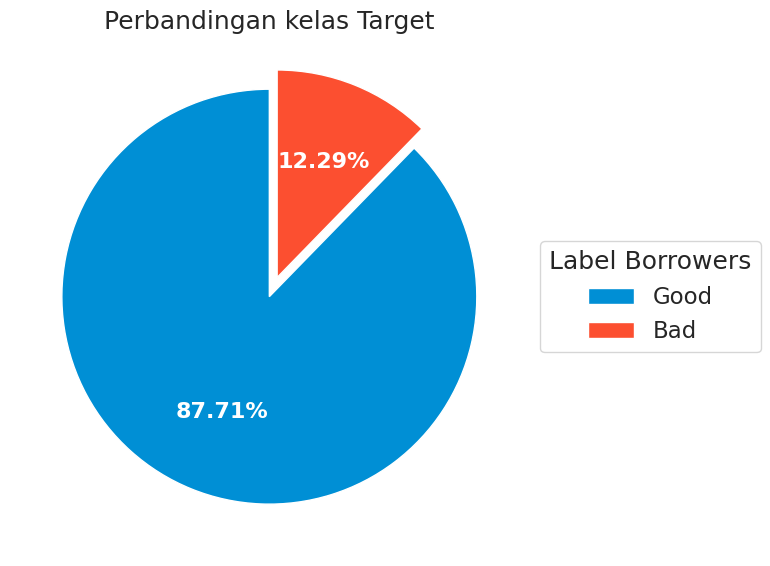

In [6]:
pie_data = data['label'].value_counts(normalize=True).values * 100
pie_label = data['label'].value_counts(normalize=True).index

fig, ax = plt.subplots(figsize=(8,6))
wedges, texts, autotexts = ax.pie(pie_data,
                                  startangle=90, explode=[0, 0.1],
                                  autopct='%.2f%%', textprops={'color':'w', 'fontsize':16, 'weight':'bold'})

ax.legend(wedges, pie_label,
          title='Label Borrowers',
          loc='center left', bbox_to_anchor=(1, 0.5))


plt.title("Perbandingan kelas Target")
plt.tight_layout()
plt.show()

# Data Pre-processing, Cleaning, and Feature Engineering

* Periksa data (missing value, etc)

Hapus kolom-kolom berikut:

* Hapus kolom 'Unnamed: 0' yang merupakan salinan dari indeks.
* Hapus kolom yang memiliki lebih dari 50% nilai yang hilang. (kolom dengan 0 nilai unik juga merupakan kolom yang memiliki 100% nilai yang hilang)
* Hapus kolom 'application_type' dan 'policy_code' (keduanya hanya memiliki 1 nilai unik).
* Hapus kolom-kolom identitas: id, member_id, title, emp_title, url, zip_code, desc, policy_code (tidak dapat digunakan dalam membangun model).
* Hapus kolom sub_grade, karena berisi informasi yang sama dengan kolom grade.

In [7]:
data.isna().mean().sort_values(ascending=False).head(25)

open_acc_6m                    1.000000
il_util                        1.000000
verification_status_joint      1.000000
dti_joint                      1.000000
annual_inc_joint               1.000000
open_il_6m                     1.000000
open_il_12m                    1.000000
open_il_24m                    1.000000
mths_since_rcnt_il             1.000000
total_bal_il                   1.000000
open_rv_12m                    1.000000
all_util                       1.000000
inq_last_12m                   1.000000
total_cu_tl                    1.000000
inq_fi                         1.000000
open_rv_24m                    1.000000
max_bal_bc                     1.000000
mths_since_last_record         0.865666
mths_since_last_major_derog    0.787739
desc                           0.729815
mths_since_last_delinq         0.536906
next_pymnt_d                   0.487286
tot_cur_bal                    0.150715
tot_coll_amt                   0.150715
total_rev_hi_lim               0.150715


In [8]:
data.nunique()[data.nunique() < 2].sort_values()

mths_since_rcnt_il           0
inq_fi                       0
all_util                     0
max_bal_bc                   0
open_rv_24m                  0
open_rv_12m                  0
il_util                      0
total_bal_il                 0
total_cu_tl                  0
inq_last_12m                 0
open_il_12m                  0
open_il_6m                   0
open_acc_6m                  0
verification_status_joint    0
dti_joint                    0
annual_inc_joint             0
open_il_24m                  0
application_type             1
policy_code                  1
dtype: int64

In [9]:
data.drop(['Unnamed: 0', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog',
                'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m',
                'open_il_12m', 'open_il_24m','mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
                'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'policy_code',
                'application_type','id', 'member_id', 'sub_grade', 'emp_title', 'url', 'title',
                'zip_code'], axis=1, inplace = True)

# Data Understanding

## Data Leakage

Pemahaman data/kolom sangat penting. Misalnya Kita ingin memprediksi apakah suatu pinjaman berisiko atau tidak, sebelum kami berinvestasi pada pinjaman tersebut, bukan setelahnya. Masalah dengan data terletak pada kolom-kolom yang terkait dengan status terkini pinjaman. Kita hanya dapat memperoleh data dari kolom-kolom tersebut setelah pinjaman diterbitkan, dengan kata lain, setelah kita berinvestasi pada pinjaman tersebut.

* Kolom-kolom yang terkait dengan status terkini pinjaman (setelah diterbitkan): `issue_d`, `loan_status`, `pymnt_plan`, `out_prncp`, `out_prncp_inv`, `total_pymnt`, `total_pymnt_in`, `total_rec_prncp`, `total_rec_int`, `total_rec_late_fee`, `recoveries`, `collection_recovery_fee`, `last_pymnt_d`, `last_pymnt_amnt`, `next_pymnt_d`.

Misalnya, `out_prncp` (sisa pokok pinjaman (sisa pokok pinjaman untuk total dana yang dibiayai)), ketika out_prncp adalah 0, itu berarti pinjaman tersebut sudah lunas sepenuhnya, sangat mudah untuk diprediksi hanya berdasarkan satu variabel ini, dan hasilnya akan sangat akurat. Contoh lainnya adalah `recoveries`, recoveries hanya terjadi setelah peminjam tidak mampu membayar pinjaman dan lembaga pemberi pinjaman memulai proses pemulihan pinjaman. Tentu saja, kami tahu bahwa pinjaman tersebut buruk dan berisiko, hanya dari informasi ini saja. Variabel-variabel tersebut dapat memprediksi dengan sangat akurat karena sudah terjadi.

Dalam ilmu data, jenis variabel seperti ini disebut Data Leakage. Data Leakage adalah terciptanya informasi tambahan yang tidak terduga dalam data pelatihan, yang memungkinkan model atau algoritme pembelajaran mesin membuat prediksi yang tidak realistis. Ini adalah data yang tidak akan kami dapatkan saat menggunakan model dalam implementasi. Kami tidak akan mengetahui apakah akan ada biaya pemulihan, atau apakah pokok pinjaman akan menjadi 0 atau tidak sebelum pinjaman berakhir. Kami tidak akan mendapatkan data-data tersebut sebelum berinvestasi pada pinjaman.

Oleh karena itu, kolom-kolom yang mengandung Data Leakage akan dihapus dan hanya akan mempertahankan kolom dengan data yang dapat diperoleh sebelum pinjaman diinvestasikan.

In [10]:
leakage_col = ['issue_d', 'loan_status', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
                'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d']

data.drop(columns=leakage_col, axis=1, inplace=True)

## Correlation

<ipython-input-11-6cceebd5db97>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, annot_kws={'size':14})


<Axes: >

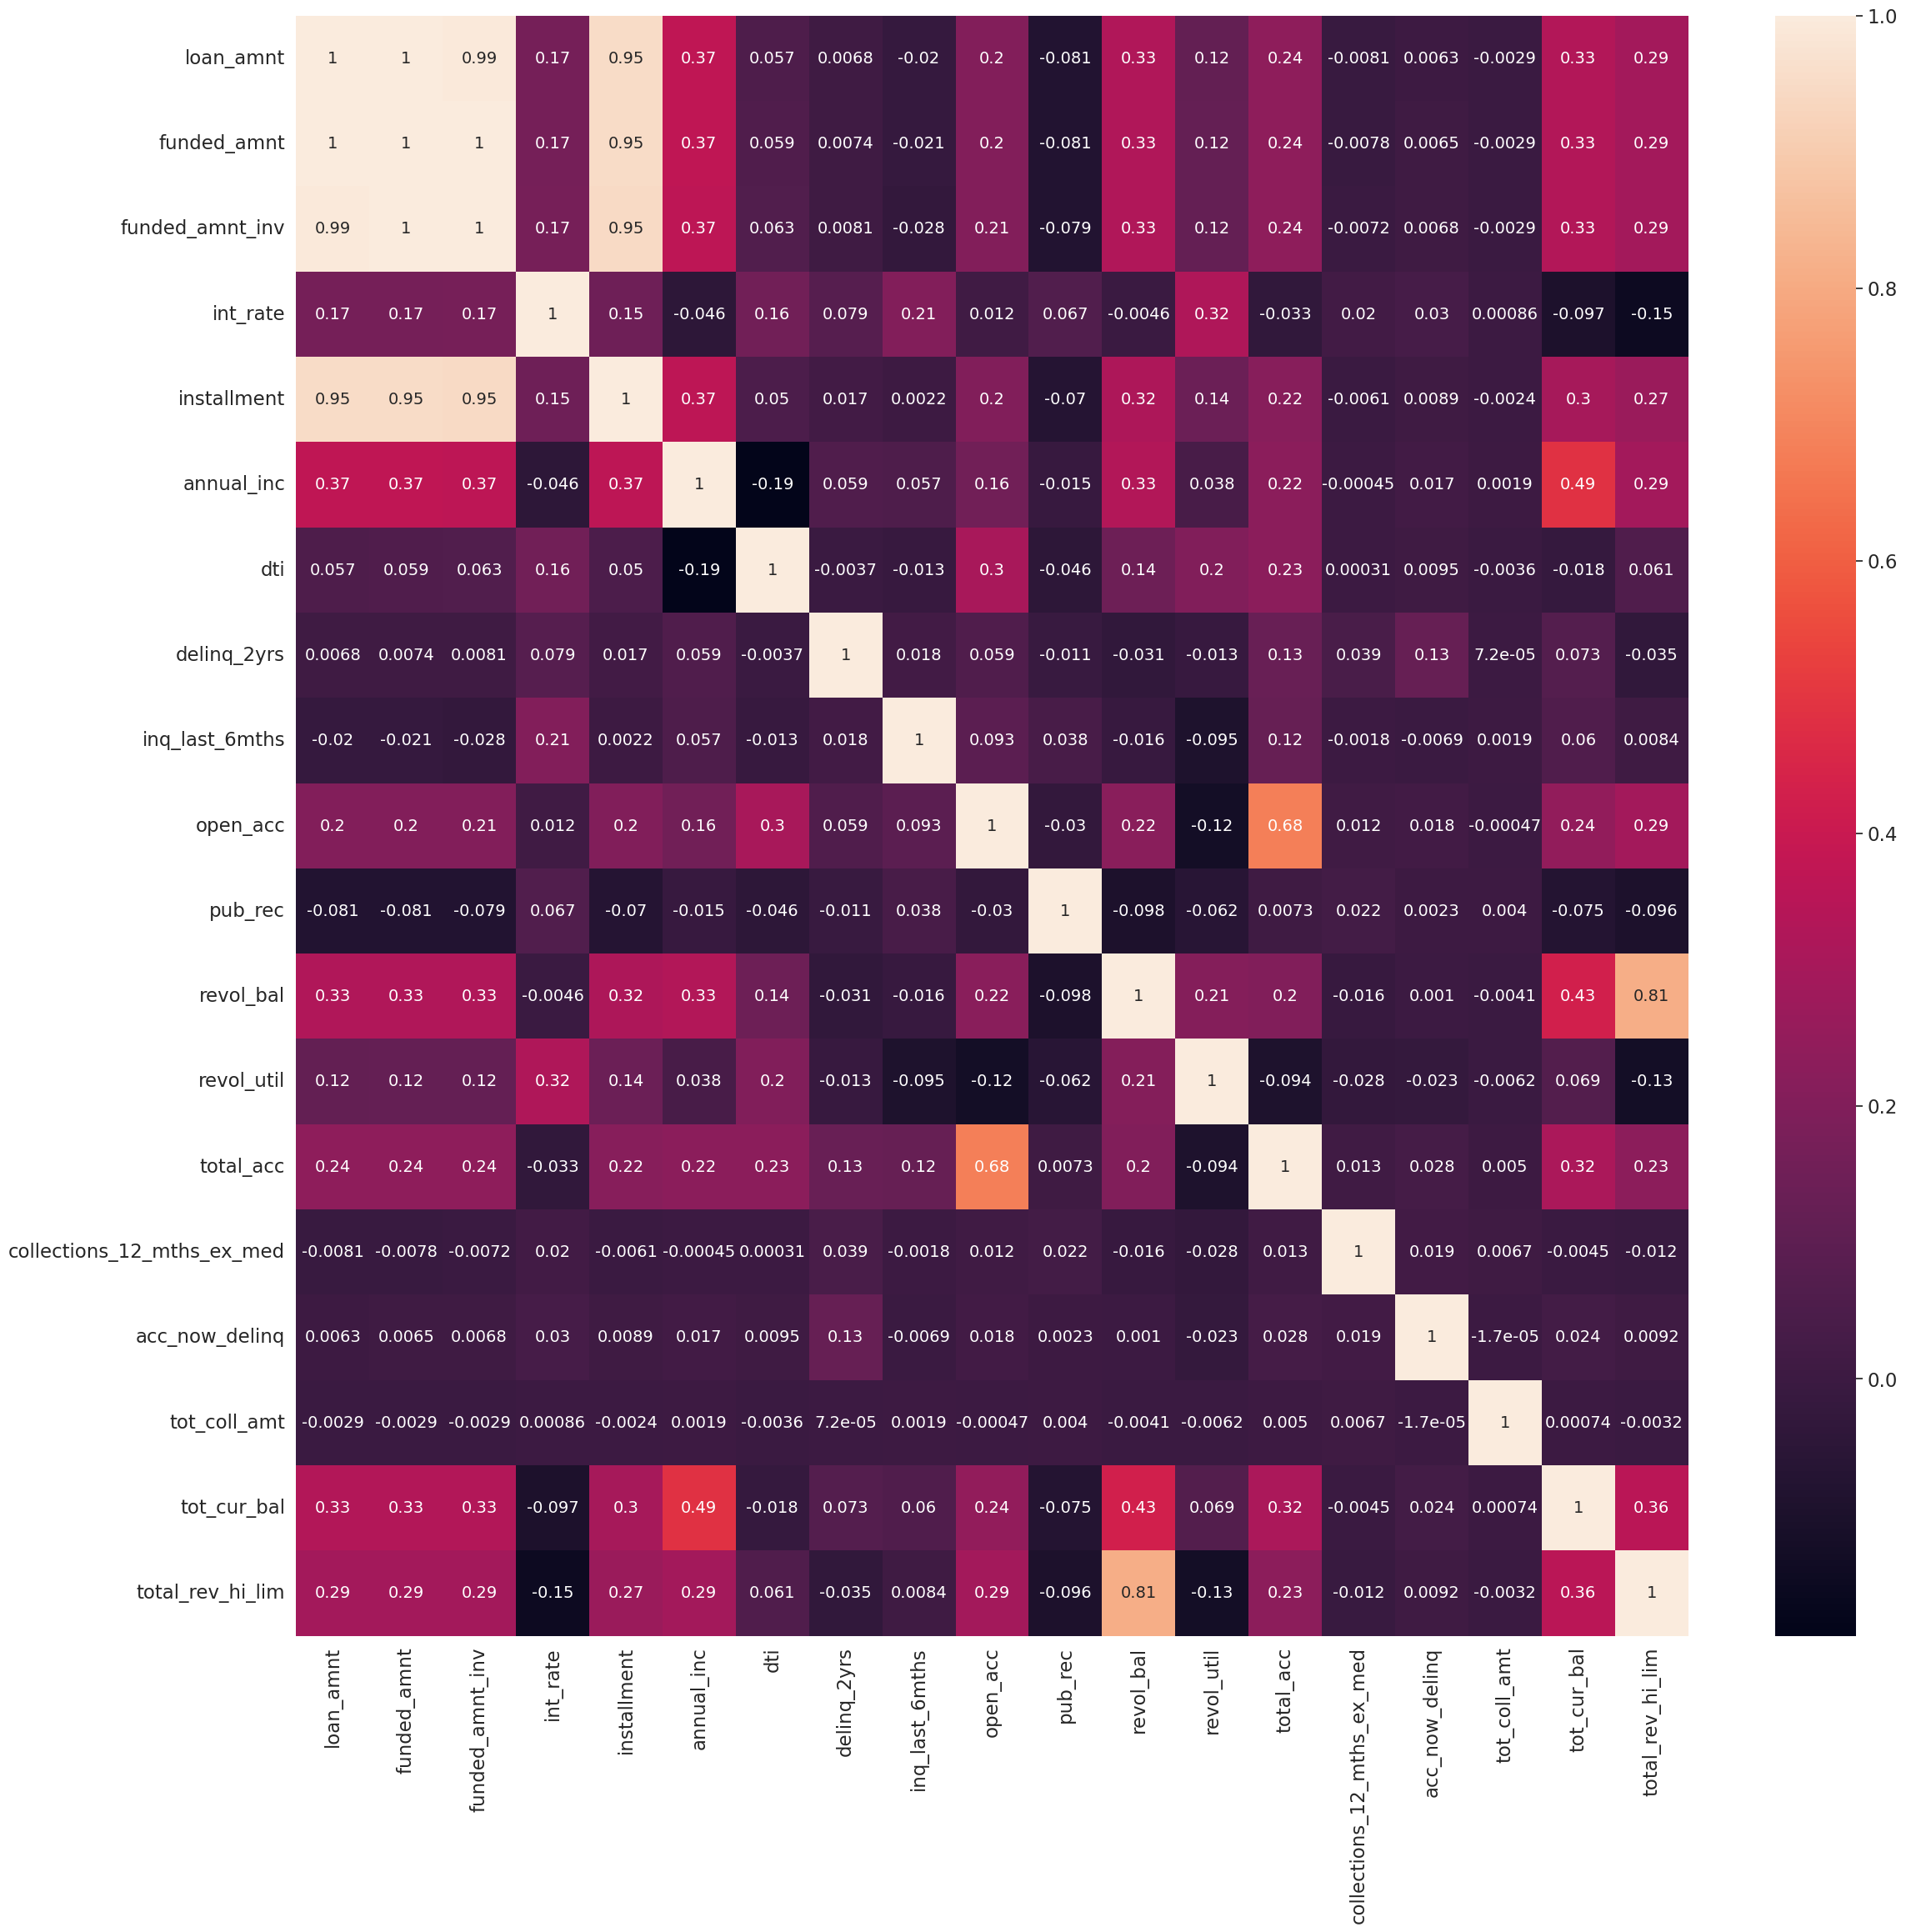

In [11]:
plt.figure(figsize=(24,24))
sns.heatmap(data.corr(), annot=True, annot_kws={'size':14})

*Kolom-kolom `loan_amnt`, `funded_amnt`, dan `funded_amnt_inv` memiliki korelasi yang mirip dengan kolom-kolom lainnya. Oleh karena itu, kemungkinan kolom-kolom ini memiliki data yang hampir sama*

In [12]:
# Periksa kolom-kolom yang diduga serupa
data[['loan_amnt','funded_amnt','funded_amnt_inv']].describe()

,loan_amnt,funded_amnt,funded_amnt_inv
count,466285.000000,466285.000000,466285.000000
mean,14317.277577,14291.801044,14222.329888
std,8286.509164,8274.371300,8297.637788
min,500.000000,500.000000,0.000000
25%,8000.000000,8000.000000,8000.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,19950.000000
max,35000.000000,35000.000000,35000.000000


*Data ini sangat mirip, kita dapat menghapus 2 dari kolom tersebut*

In [13]:
data.drop(columns = ['funded_amnt', 'funded_amnt_inv'], inplace = True)

## Missing Values

In [14]:
# Periksa missing values
data.isnull().sum()

loan_amnt                         0
term                              0
int_rate                          0
installment                       0
grade                             0
emp_length                    21008
home_ownership                    0
annual_inc                        4
verification_status               0
purpose                           0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                         29
pub_rec                          29
revol_bal                         0
revol_util                      340
total_acc                        29
initial_list_status               0
last_credit_pull_d               42
collections_12_mths_ex_med      145
acc_now_delinq                   29
tot_coll_amt                  70276
tot_cur_bal                   70276
total_rev_hi_lim              70276
label                       

In [15]:
data_columns=data.columns[data.isnull().any()].tolist()
data[data_columns].isnull().sum()*100/len(data)

emp_length                     4.505399
annual_inc                     0.000858
delinq_2yrs                    0.006219
earliest_cr_line               0.006219
inq_last_6mths                 0.006219
open_acc                       0.006219
pub_rec                        0.006219
revol_util                     0.072917
total_acc                      0.006219
last_credit_pull_d             0.009007
collections_12_mths_ex_med     0.031097
acc_now_delinq                 0.006219
tot_coll_amt                  15.071469
tot_cur_bal                   15.071469
total_rev_hi_lim              15.071469
dtype: float64

`tot_coll_amt`, `tot_cur_bal`, `total_rev_hi_lim` memiliki jumlah nilai yang hilang yang sama sebesar 15% dari seluruh data. Oleh karena itu, ketiga kolom tersebut akan diperiksa.

* `tot_coll_amt`: Jumlah total tagihan yang pernah harus dibayar
* `tot_cur_bal`: Saldo total saat ini dari semua akun
* `total_rev_hi_lim`: Batas kredit/limit kredit total yang tersedia

In [16]:
total_cols = ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

data[total_cols].head(10)

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


In [17]:
data[total_cols].sample(10)

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
417965,0.0,175596.0,23700.0
157439,220.0,9657.0,14400.0
294624,0.0,55556.0,20100.0
373406,0.0,100981.0,62400.0
401414,0.0,58990.0,8200.0
41658,NaN,NaN,NaN
258177,0.0,175903.0,52800.0
131665,0.0,104889.0,19700.0
105303,0.0,13430.0,43016.0
364422,0.0,181978.0,10700.0


*Seperti yang ditunjukkan dalam data di atas, kolom ini memiliki lokasi nilai yang hilang yang serupa.*

In [18]:
data[total_cols].describe()

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,3.960090e+05,3.960090e+05,3.960090e+05
mean,1.919135e+02,1.388017e+05,3.037909e+04
std,1.463021e+04,1.521147e+05,3.724713e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.861800e+04,1.350000e+04
50%,0.000000e+00,8.153900e+04,2.280000e+04
75%,0.000000e+00,2.089530e+05,3.790000e+04
max,9.152545e+06,8.000078e+06,9.999999e+06


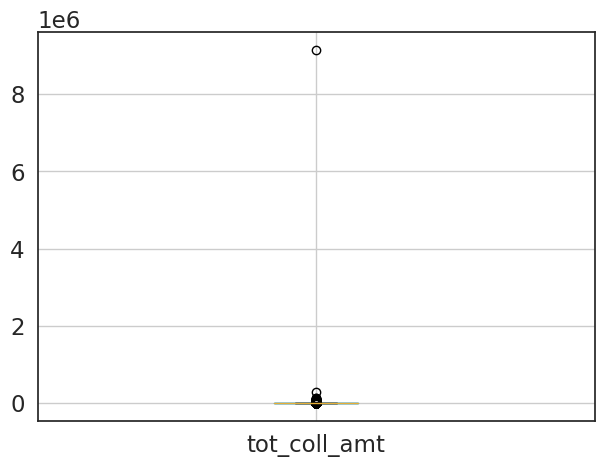

In [19]:
data.boxplot(column=['tot_coll_amt'])
plt.show()

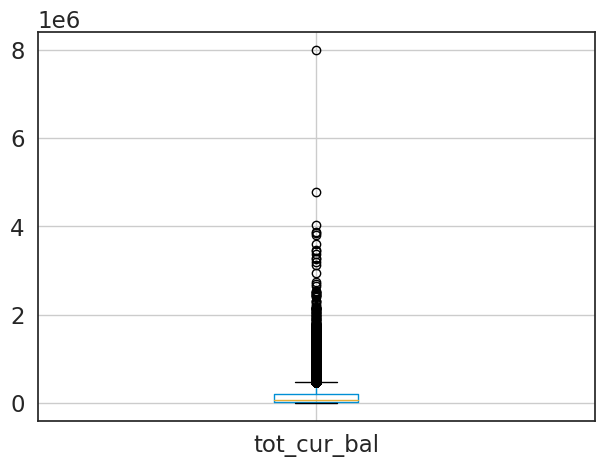

In [20]:
data.boxplot(column=['tot_cur_bal'])
plt.show()

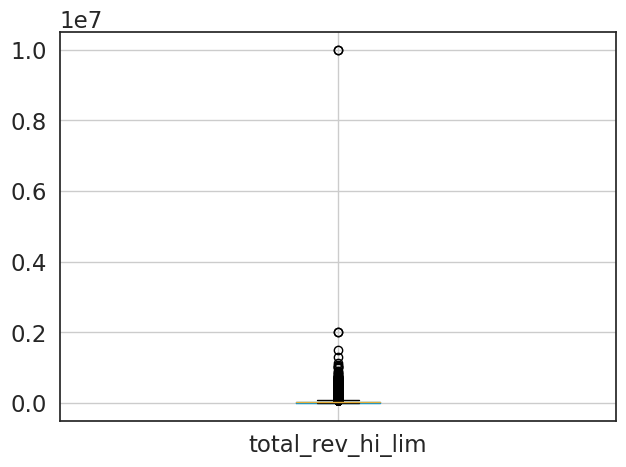

In [21]:
data.boxplot(column=['total_rev_hi_lim'])
plt.show()

Kesimpulan:

* 75% dari tot_coll_amt bernilai 0.
* Data untuk setiap baris cukup berbeda sehingga tidak mungkin mengisi nilai yang hilang dengan nilai rata-rata atau nilai lainnya.
* Jumlah total nilai yang hilang adalah 70276, yang merupakan 15,07% dari seluruh data.
* Oleh karena itu, baris-baris yang memiliki nilai yang hilang pada kolom-kolom tersebut akan dihapus.

In [22]:
data.dropna(subset = ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'], inplace = True)

In [23]:
data.reset_index(drop= True, inplace = True)

## Data Type Transformation

Mengubah tipe data yang tidak sesuai.

In [24]:
continuous_cols = ['term', 'emp_length', 'earliest_cr_line', 'last_credit_pull_d']
data[continuous_cols]

,term,emp_length,earliest_cr_line,last_credit_pull_d
0,36 months,10+ years,Oct-86,Dec-15
1,36 months,1 year,Jan-07,Jan-16
2,36 months,10+ years,Mar-94,Jan-16
3,36 months,10+ years,Oct-98,Jan-16
4,36 months,2 years,Mar-98,Jan-16
...,...,...,...,...
396004,60 months,4 years,Apr-03,Jan-16
396005,60 months,10+ years,Jun-97,Jan-16
396006,60 months,7 years,Dec-01,Dec-15
396007,36 months,3 years,Feb-03,Apr-15


### 1. term

`term`: Jumlah pembayaran atas pinjaman. Nilai dalam beberapa bulan dan dapat berupa 36 atau 60.

In [25]:
# Ubah ke tipe data numerik
data['term'] = pd.to_numeric(data['term'].str.replace(' months', ''))
data['term']

0         36
1         36
2         36
3         36
4         36
          ..
396004    60
396005    60
396006    60
396007    36
396008    36
Name: term, Length: 396009, dtype: int64

### 2. emp_length

`emp_length`: Lama pekerjaan dalam beberapa tahun. Nilai yang mungkin adalah antara 0 dan 10 di mana 0 berarti kurang dari satu tahun dan 10 berarti sepuluh tahun atau lebih.

In [26]:
data['emp_length'].unique()

array(['10+ years', '1 year', '2 years', '4 years', '3 years', '7 years',
       '5 years', '6 years', '9 years', '8 years', '< 1 year', nan],
      dtype=object)

In [27]:
emp_map = {
    '< 1 year' : '0',
    '1 year' : '1',
    '2 years' : '2',
    '3 years' : '3',
    '4 years' : '4',
    '5 years' : '5',
    '6 years' : '6',
    '7 years' : '7',
    '8 years' : '8',
    '9 years' : '9',
    '10+ years' : '10'
}

data['emp_length'] = data['emp_length'].map(emp_map).fillna('0').astype(int)
data['emp_length'].unique()

array([10,  1,  2,  4,  3,  7,  5,  6,  9,  8,  0])

### 3. earliest_cr_line

`earliest_cr_line`:Bulan ketika garis kredit tercatat peminjam dibuka

In [28]:
data['earliest_cr_line_date'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%y')

In [29]:
data['earliest_cr_line_date']

0        1986-10-01
1        2007-01-01
2        1994-03-01
3        1998-10-01
4        1998-03-01
            ...    
396004   2003-04-01
396005   1997-06-01
396006   2001-12-01
396007   2003-02-01
396008   2000-02-01
Name: earliest_cr_line_date, Length: 396009, dtype: datetime64[ns]

In [30]:
# Asumsikan sekarang bulan Desember 2017
data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))

In [31]:
data['mths_since_earliest_cr_line'].describe()

count    396009.000000
mean        238.898512
std          95.101534
min        -612.000000
25%         182.000000
50%         224.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [32]:
data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date',
                   'mths_since_earliest_cr_line']][data['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
628,Oct-68,2068-10-01,-610.0
843,Aug-67,2067-08-01,-596.0
1021,Jul-67,2067-07-01,-595.0
1740,Apr-68,2068-04-01,-604.0
3645,Jan-61,2061-01-01,-517.0
...,...,...,...
393727,Jan-68,2068-01-01,-601.0
393984,Jul-66,2066-07-01,-583.0
394824,Oct-67,2067-10-01,-598.0
395224,Sep-67,2067-09-01,-597.0


*Tanggal sebelum tahun 1970 tidak dikonversi dengan baik, menjadi tahun 2069 dan sejenisnya, dan perbedaan negatif dihitung.*

In [33]:
data['earliest_cr_line_date'] = data['earliest_cr_line_date'].astype(str)
data['earliest_cr_line_date'][data['mths_since_earliest_cr_line'] < 0] = data['earliest_cr_line_date'][data['mths_since_earliest_cr_line'] < 0].str.replace('20','19')

<ipython-input-33-5282bf3d9b6a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['earliest_cr_line_date'][data['mths_since_earliest_cr_line'] < 0] = data['earliest_cr_line_date'][data['mths_since_earliest_cr_line'] < 0].str.replace('20','19')


In [34]:
# ubah type data ke datetime
data['earliest_cr_line_date'] = pd.to_datetime(data['earliest_cr_line_date'])
data['earliest_cr_line_date']

0        1986-10-01
1        2007-01-01
2        1994-03-01
3        1998-10-01
4        1998-03-01
            ...    
396004   2003-04-01
396005   1997-06-01
396006   2001-12-01
396007   2003-02-01
396008   2000-02-01
Name: earliest_cr_line_date, Length: 396009, dtype: datetime64[ns]

In [35]:
# Asumsikan sekarang bulan Desember 2015
data['mths_since_earliest_cr_line_date'] = round(pd.to_numeric((pd.to_datetime('2015-12-01') - data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))

data['mths_since_earliest_cr_line_date'].describe()

count    396009.000000
mean        218.040865
std          87.849670
min          49.000000
25%         159.000000
50%         201.000000
75%         262.000000
max         863.000000
Name: mths_since_earliest_cr_line_date, dtype: float64

*Tidak ada lagi nilai negatif. Dan data telah dikonversi dengan baik.*

In [36]:
data.drop(columns = ['earliest_cr_line_date' ,'mths_since_earliest_cr_line',
                    'earliest_cr_line'], inplace = True)

### 4. last_credit_pull_d

`last_credit_pull_d`: Bulan di mana pinjaman dibiayai.

In [37]:
# Asumsikan sekarang bulan Desember 2017
# Ekstrak tanggal dan waktu dari variabel string yang memiliki format tertentu, dan isi data NaN dengan tanggal maksimum
data['last_credit_pull_d'] = pd.to_datetime(data['last_credit_pull_d'], format = '%b-%y').fillna(pd.to_datetime("2016-01-01"))

# Menghitung selisih antara dua tanggal dalam bulan, mengubahnya menjadi tipe data numerik, dan membulatkannya.
data['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['last_credit_pull_d']) / np.timedelta64(1, 'M')))

data['mths_since_last_credit_pull_d'].describe()

count    396009.000000
mean         25.105753
std           5.213815
min          23.000000
25%          23.000000
50%          23.000000
75%          23.000000
max          64.000000
Name: mths_since_last_credit_pull_d, dtype: float64

*Tidak ada lagi nilai negatif. Dan data telah dikonversi dengan baik.*

In [38]:
data.drop(columns = ['last_credit_pull_d'], inplace = True)

## Periksa missing value lagi

In [39]:
data.isnull().sum()

loan_amnt                             0
term                                  0
int_rate                              0
installment                           0
grade                                 0
emp_length                            0
home_ownership                        0
annual_inc                            0
verification_status                   0
purpose                               0
addr_state                            0
dti                                   0
delinq_2yrs                           0
inq_last_6mths                        0
open_acc                              0
pub_rec                               0
revol_bal                             0
revol_util                          219
total_acc                             0
initial_list_status                   0
collections_12_mths_ex_med            0
acc_now_delinq                        0
tot_coll_amt                          0
tot_cur_bal                           0
total_rev_hi_lim                      0


In [40]:
data.dropna(subset = ['revol_util'], inplace = True)

data.reset_index(drop= True, inplace = True)

In [41]:
data.isnull().sum()

loan_amnt                           0
term                                0
int_rate                            0
installment                         0
grade                               0
emp_length                          0
home_ownership                      0
annual_inc                          0
verification_status                 0
purpose                             0
addr_state                          0
dti                                 0
delinq_2yrs                         0
inq_last_6mths                      0
open_acc                            0
pub_rec                             0
revol_bal                           0
revol_util                          0
total_acc                           0
initial_list_status                 0
collections_12_mths_ex_med          0
acc_now_delinq                      0
tot_coll_amt                        0
tot_cur_bal                         0
total_rev_hi_lim                    0
label                               0
mths_since_e

*Tidak ada missing value*

## Explore Data

In [42]:
def risk_percentage(x):
    ratio = (data.groupby(x)['label'] # group by
         .value_counts(normalize=True) # menghitung rasio
         .mul(100) # mengubah ke persen
         .rename('risky (%)') # rename kolom
         .reset_index())

    sns.lineplot(data=ratio[ratio['label'] == 'Bad'], x=x, y='risky (%)')
    plt.title(x)
    plt.show()

In [43]:
print(data.nunique()[data.nunique() < 12].sort_values().index)

Index(['term', 'initial_list_status', 'label', 'verification_status',
       'home_ownership', 'acc_now_delinq', 'grade', 'inq_last_6mths',
       'collections_12_mths_ex_med', 'emp_length'],
      dtype='object')


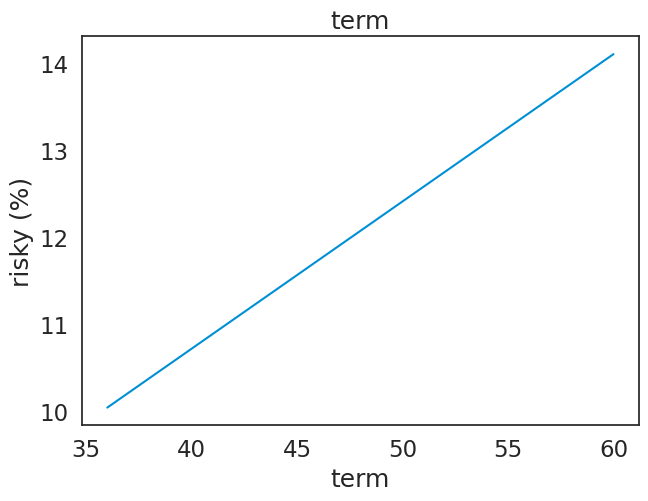

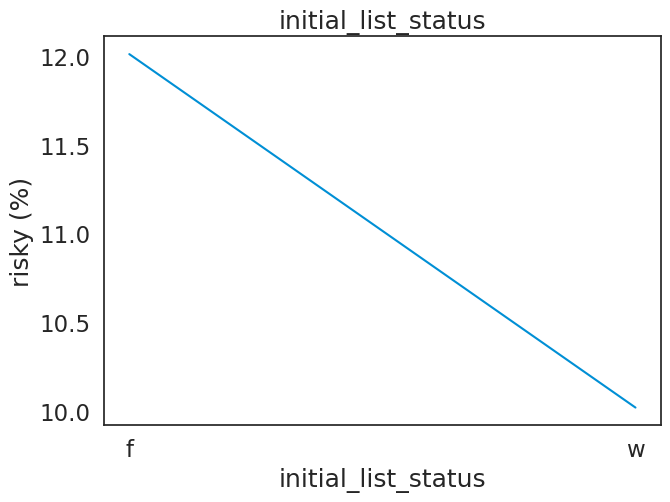

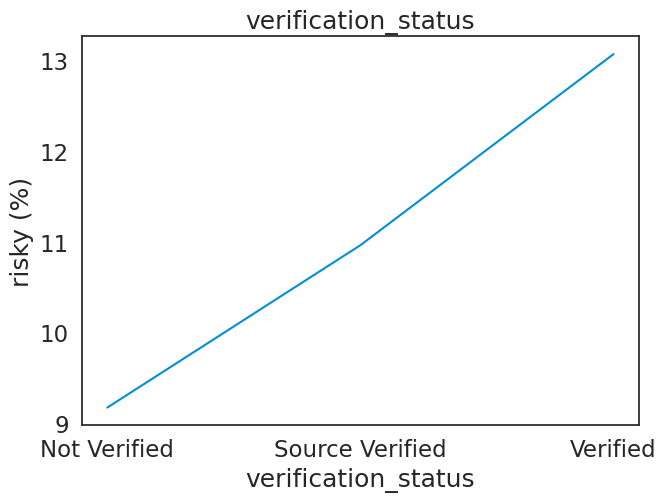

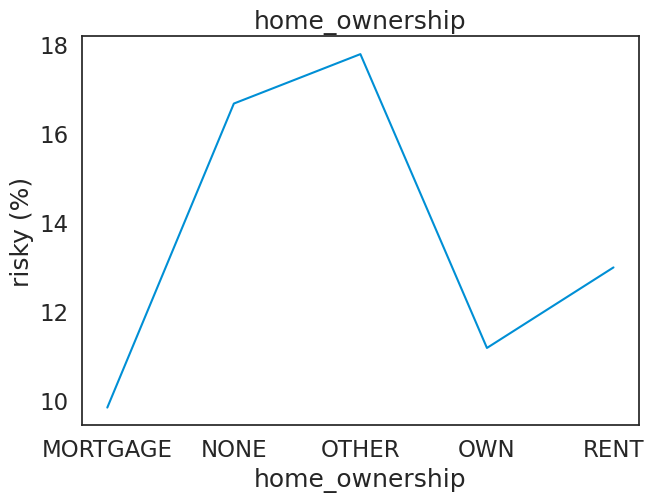

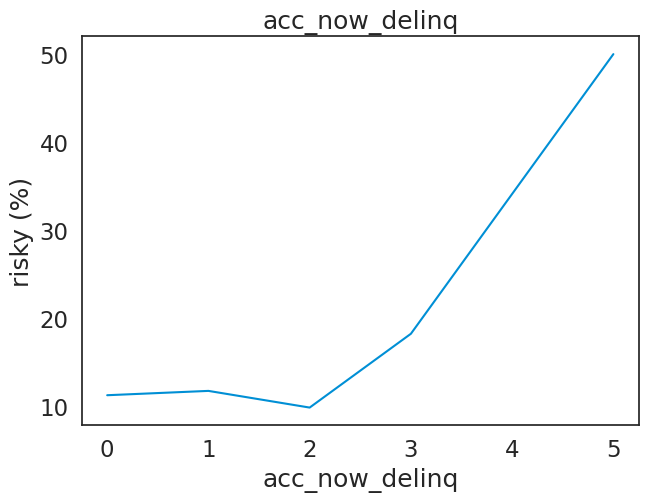

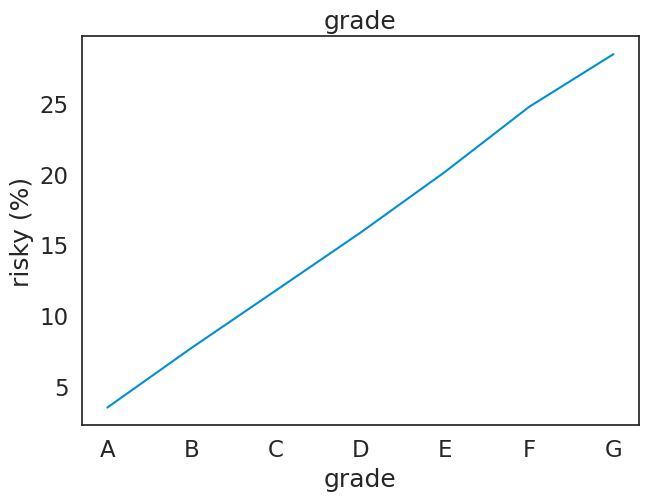

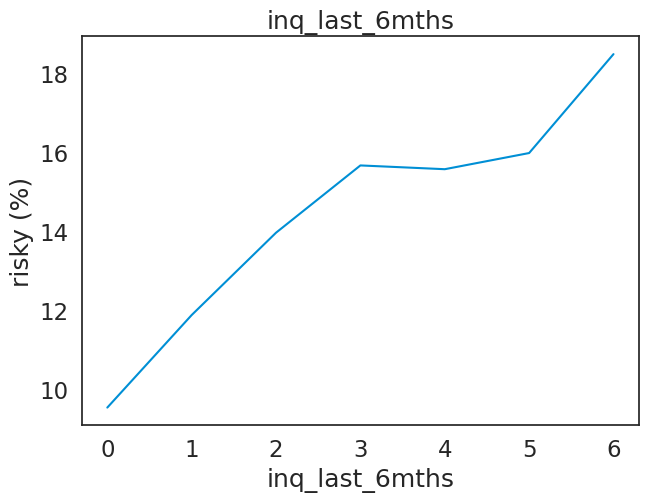

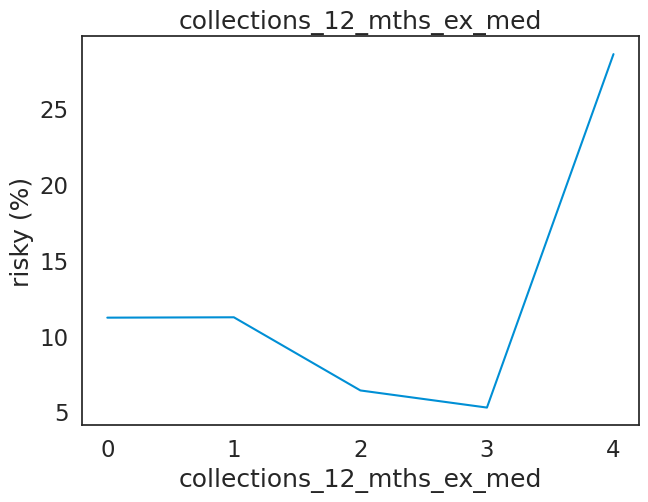

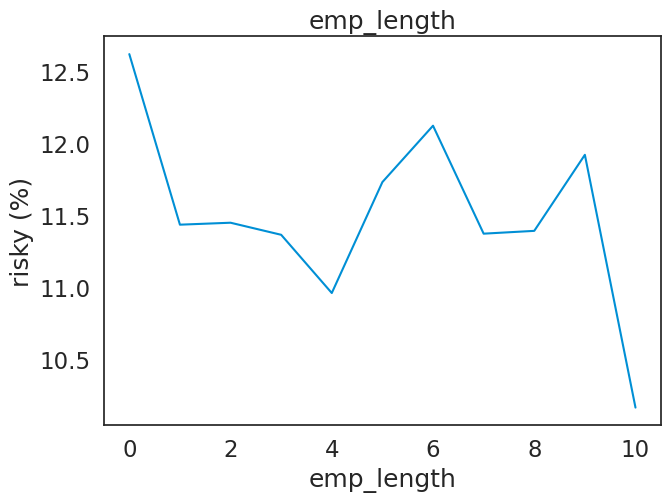

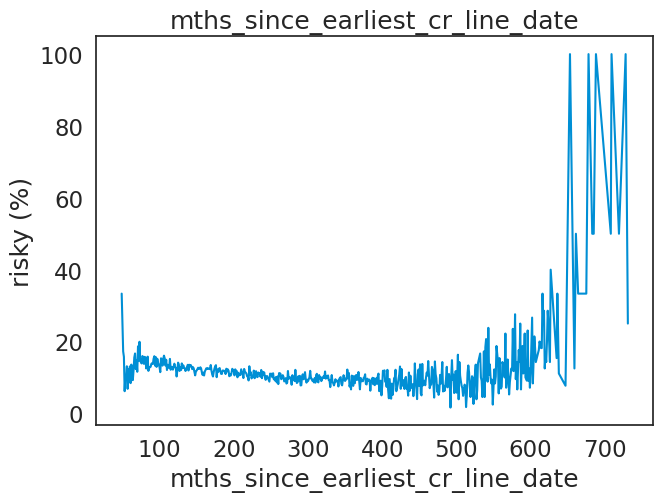

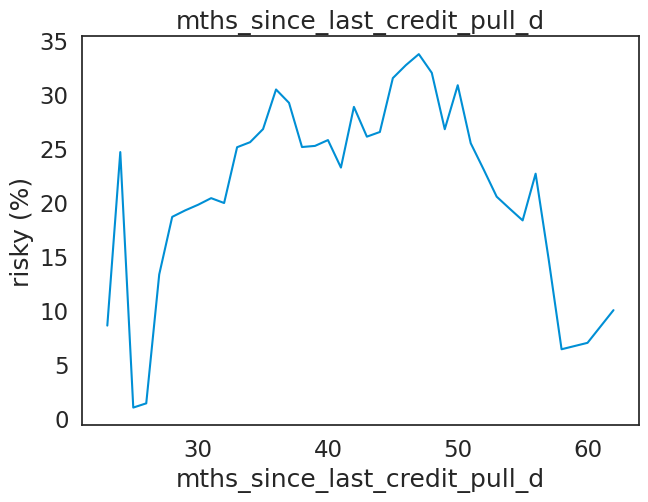

In [44]:
unq_cols = ['term', 'initial_list_status', 'verification_status',
            'home_ownership', 'acc_now_delinq', 'grade', 'inq_last_6mths',
            'collections_12_mths_ex_med', 'emp_length',
            'mths_since_earliest_cr_line_date', 'mths_since_last_credit_pull_d']

for col in unq_cols:
    risk_percentage(col)

Kesimpulan:

* `term`: memiliki risiko rendah pada periode 36 bulan dan risiko tinggi pada periode 60 bulan
* `initial_list_status`: memiliki risiko tinggi pada status f dan risiko rendah pada status w
* `verification_status`: memiliki risiko tinggi pada status terverifikasi
* `home_ownership`: memiliki risiko tinggi pada jenis kepemilikan None dan Other.
* `acc_now_delinq`: memiliki risiko rendah dengan nilai 2, 0, 1, dan memiliki risiko tinggi dengan nilai 3, 4, 5
* `grade`: terdapat peningkatan risiko yang terkait dengan ini.
* `inq_last_6mths`: terdapat peningkatan risiko yang terkait dengan ini.
* `collections_12_mths_ex_med`: memiliki risiko rendah dengan nilai 3.0 dan memiliki risiko tinggi dengan nilai 4.0
* `emp_length`:Lama bekerja kurang dari 1 tahun memiliki persentase risiko terbesar dan lama bekerja lebih dari 9 tahun memiliki persentase risiko terkecil
* `mths_since_earliest_cr_line_date`: Semakin awal batas kredit, semakin stabil catatan peminjam, dan terdapat peningkatan risiko yang terkait dengan ini.
* `mths_since_last_credit_pull_d`: memiliki variasi risiko yang berbeda-beda.

## Encoding

In [45]:
label_map = {'Bad': 0, 'Good': 1}

data['label'] = data['label'].map(label_map)
data['label'].unique()

array([1, 0])

In [46]:
# One Hot Encoding

cat_cols = [col for col in data.select_dtypes(include='object').columns.tolist()]
onehot_cols = pd.get_dummies(data[cat_cols], drop_first=True)

In [47]:
onehot_cols

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395785,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
395786,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
395787,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395788,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## Standardization

In [48]:
num_cols = [col for col in data.columns.tolist() if col not in cat_cols + ['label']]
ss = StandardScaler()
std_cols = pd.DataFrame(ss.fit_transform(data[num_cols]), columns=num_cols)

In [49]:
std_cols

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line_date,mths_since_last_credit_pull_d
0,1.482304,-0.628484,-0.699079,1.806077,1.103795,-0.348742,0.652418,-0.369343,-0.748128,0.508315,...,0.958852,0.187888,0.126859,-0.090792,-0.063207,-0.013114,-0.157387,0.792444,1.502075,-0.211973
1,-0.600984,-0.628484,-0.016149,-0.459988,-1.286424,-0.879818,0.938065,-0.369343,-0.748128,0.110319,...,-0.411000,-0.178038,0.213154,-0.090792,-0.063207,-0.013114,-0.819722,-0.410481,-1.263790,-0.403817
2,-0.330036,-0.628484,-1.697208,-0.315117,1.103795,0.566906,-0.467318,-0.369343,0.216907,0.110319,...,-0.162505,-1.537192,-0.304615,-0.090792,-0.063207,-0.013114,0.847596,0.824665,0.489063,-0.403817
3,-0.330036,-0.628484,-0.118931,-0.155313,1.103795,-0.623436,-0.100420,-0.369343,-0.748128,-0.884670,...,-0.525429,0.518964,0.558333,-0.090792,-0.063207,1.038259,-0.823129,-0.598438,-0.136956,-0.403817
4,0.031228,-0.628484,-1.176445,0.127371,-1.020844,-0.202238,-0.155011,-0.369343,-0.748128,-0.685672,...,-0.245496,0.754202,0.299449,-0.090792,-0.063207,0.090342,0.879466,-0.402426,-0.057281,-0.403817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395785,0.440660,1.591130,0.095770,-0.051758,-0.489684,0.658471,0.269017,-0.369343,1.181941,1.304307,...,0.317189,0.902315,0.903513,-0.090792,-0.063207,-0.013114,1.027479,-0.013086,-0.751593,-0.403817
395786,0.874177,1.591130,1.351996,0.563089,1.103795,0.072456,0.091281,-0.369343,4.077043,1.304307,...,0.079731,-0.461195,0.385744,-0.090792,-0.063207,-0.013114,0.546283,0.241998,0.045159,-0.403817
395787,0.717629,1.591130,0.671350,0.283442,0.307055,-0.513559,1.005351,-0.369343,1.181941,1.304307,...,-0.472108,-0.252094,1.507577,-0.090792,-0.063207,-0.013114,-0.428579,-0.464183,-0.569478,-0.211973
395788,-1.534248,-0.628484,-1.404850,-1.570003,-0.755264,0.164021,-1.566742,3.227338,0.216907,1.901301,...,-0.246786,-1.541549,0.126859,-0.090792,-0.063207,-0.013114,2.978176,0.609857,-0.728828,1.322778


In [50]:
std_cols.describe()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line_date,mths_since_last_credit_pull_d
count,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,...,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05,3.957900e+05
mean,-9.823618e-17,8.864954e-17,-7.760515e-16,-1.665994e-16,1.552893e-17,4.502492e-16,4.075222e-16,-3.482789e-17,5.708901e-17,-8.322788e-17,...,-7.970918e-18,-1.729815e-16,-7.812936e-17,-4.685607e-18,6.786052e-18,-3.691487e-19,4.222432e-17,-3.077062e-17,1.524528e-16,-2.591267e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.654669e+00,-6.284841e-01,-1.838819e+00,-1.731367e+00,-1.552004e+00,-1.301016e+00,-2.251025e+00,-3.693431e-01,-7.481275e-01,-2.078658e+00,...,-7.916497e-01,-2.478145e+00,-2.030512e+00,-9.079171e-02,-6.320729e-02,-1.311407e-02,-9.126034e-01,-8.132460e-01,-1.923955e+00,-4.038173e-01
25%,-7.725838e-01,-6.284841e-01,-6.990792e-01,-7.210086e-01,-1.020844e+00,-5.318715e-01,-7.529651e-01,-3.693431e-01,-7.481275e-01,-6.856723e-01,...,-4.710095e-01,-7.138584e-01,-7.360895e-01,-9.079171e-02,-6.320729e-02,-1.311407e-02,-7.244076e-01,-4.534425e-01,-6.719174e-01,-4.038173e-01
50%,-2.096146e-01,-6.284841e-01,-1.614877e-02,-2.157884e-01,4.147525e-02,-1.839252e-01,-4.963860e-02,-3.693431e-01,-7.481275e-01,-8.867850e-02,...,-2.142489e-01,4.848776e-02,-1.320255e-01,-9.079171e-02,-6.320729e-02,-1.311407e-02,-3.764892e-01,-2.010431e-01,-1.938667e-01,-4.038173e-01
75%,6.333340e-01,1.591130e+00,6.713497e-01,5.597661e-01,1.103795e+00,2.922119e-01,7.197041e-01,-3.693431e-01,2.169065e-01,5.083153e-01,...,1.997501e-01,7.759838e-01,5.583333e-01,-9.079171e-02,-6.320729e-02,-1.311407e-02,4.613969e-01,2.017219e-01,5.004451e-01,-4.038173e-01
max,2.439652e+00,1.591130e+00,2.742981e+00,3.958125e+00,1.103795e+00,1.359913e+02,2.825875e+00,3.439857e+01,6.972145e+00,1.443817e+01,...,1.219506e+02,3.639280e+01,1.125889e+01,1.696515e+02,6.715015e+01,6.254084e+02,5.170067e+01,2.676941e+02,7.341124e+00,7.461781e+00


## Combining column

In [51]:
final_data = pd.concat([onehot_cols, std_cols, data[['label']]], axis=1)
final_data.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,...,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line_date,mths_since_last_credit_pull_d,label
0,1,0,0,0,0,0,0,0,0,1,...,0.187888,0.126859,-0.090792,-0.063207,-0.013114,-0.157387,0.792444,1.502075,-0.211973,1
1,0,1,0,0,0,0,0,0,0,0,...,-0.178038,0.213154,-0.090792,-0.063207,-0.013114,-0.819722,-0.410481,-1.263790,-0.403817,1
2,0,0,0,0,0,0,1,0,0,0,...,-1.537192,-0.304615,-0.090792,-0.063207,-0.013114,0.847596,0.824665,0.489063,-0.403817,1
3,1,0,0,0,0,0,0,0,0,0,...,0.518964,0.558333,-0.090792,-0.063207,1.038259,-0.823129,-0.598438,-0.136956,-0.403817,1
4,0,0,0,0,0,0,1,0,0,0,...,0.754202,0.299449,-0.090792,-0.063207,0.090342,0.879466,-0.402426,-0.057281,-0.403817,1


## Split Data

In [52]:
# Definisikan X dan y
X = final_data.drop('label', axis = 1)
y = final_data['label']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,stratify=y)

In [54]:
X_train.shape, X_test.shape

((316632, 96), (79158, 96))

# Handling Imbalace data

## Random Oversampling

In [55]:
over = RandomOverSampler(sampling_strategy = 'minority')
X_train_over, y_train_over = over.fit_resample(X_train, y_train)

# periksa jumlah data sebelum dan sesudah oversampling
print('Sebelum OverSampling:\n{}'.format(y_train.value_counts()))
print('\nSesudah OverSampling:\n{}'.format(y_train_over.value_counts()))

Sebelum OverSampling:
1    281200
0     35432
Name: label, dtype: int64

Sesudah OverSampling:
1    281200
0    281200
Name: label, dtype: int64


## Random Undersampling

In [56]:
under = RandomUnderSampler(sampling_strategy = 'majority')
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

# periksa jumlah data sebelum dan sesudah undersampling
print('Sebelum UnderSampling:\n{}'.format(y_train.value_counts()))
print('\nSesudah UnderSampling:\n{}'.format(y_train_under.value_counts()))

Sebelum UnderSampling:
1    281200
0     35432
Name: label, dtype: int64

Sesudah UnderSampling:
0    35432
1    35432
Name: label, dtype: int64


## SMOTE

In [57]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# periksa jumlah data sebelum dan sesudah undersampling
print('Sebelum OverSampling:\n{}'.format(y_train.value_counts()))
print('\nSesudah OverSampling:\n{}'.format(y_train_smote.value_counts()))

Sebelum OverSampling:
1    281200
0     35432
Name: label, dtype: int64

Sesudah OverSampling:
1    281200
0    281200
Name: label, dtype: int64


# Modelling

## Random Forest

In [58]:
def train_random_forest(sampling_method='none'):

    model = RandomForestClassifier()

    if sampling_method == 'over':
        # Oversampling with RandomOverSampler
        model.fit(X_train_over, y_train_over)

    elif sampling_method == 'under':
        # Undersampling with RandomUnderSampler
        model.fit(X_train_under, y_train_under)

    elif sampling_method == 'smote':
        # SMOTE
        model.fit(X_train_smote, y_train_smote)

    else:
        model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    target_names = ['Bad Borrowers', 'Good Borrowers']

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names = target_names))

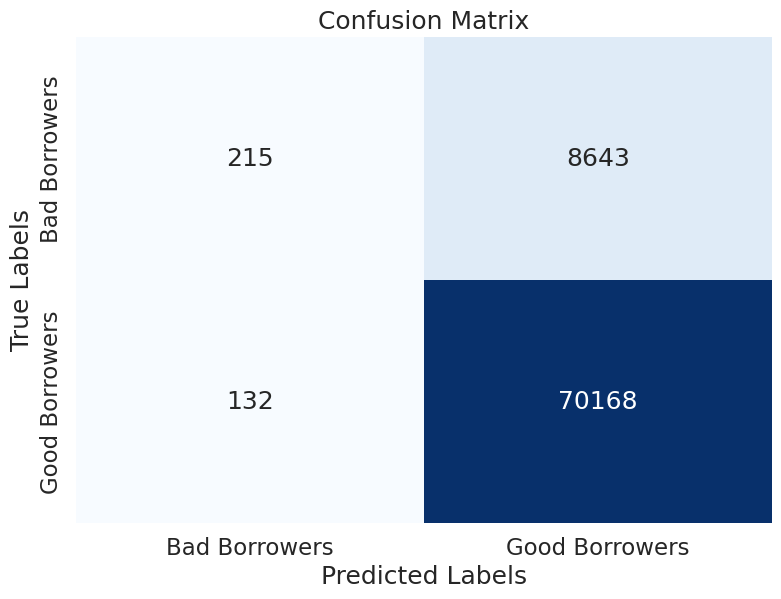

Classification Report:
                precision    recall  f1-score   support

 Bad Borrowers       0.62      0.02      0.05      8858
Good Borrowers       0.89      1.00      0.94     70300

      accuracy                           0.89     79158
     macro avg       0.75      0.51      0.49     79158
  weighted avg       0.86      0.89      0.84     79158



In [59]:
random_forest = train_random_forest()
random_forest

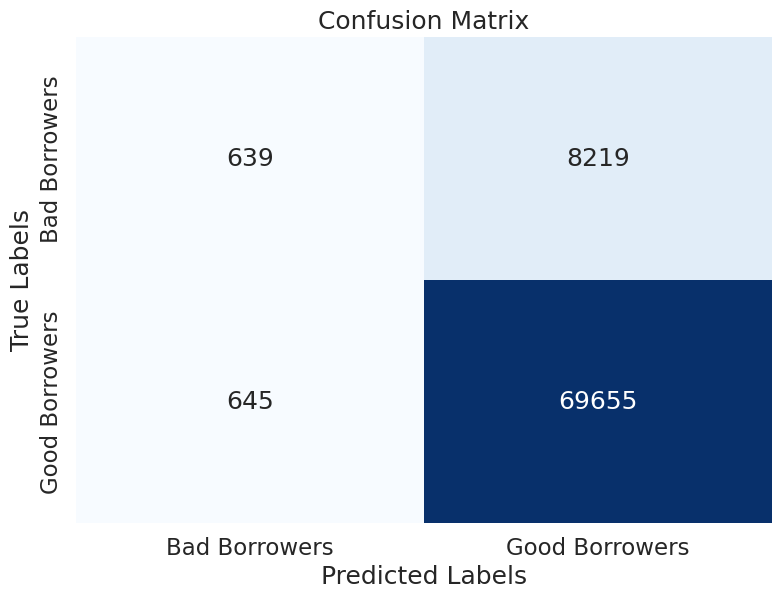

Classification Report:
                precision    recall  f1-score   support

 Bad Borrowers       0.50      0.07      0.13      8858
Good Borrowers       0.89      0.99      0.94     70300

      accuracy                           0.89     79158
     macro avg       0.70      0.53      0.53     79158
  weighted avg       0.85      0.89      0.85     79158



In [60]:
random_forest_over = train_random_forest(sampling_method='over')
random_forest_over

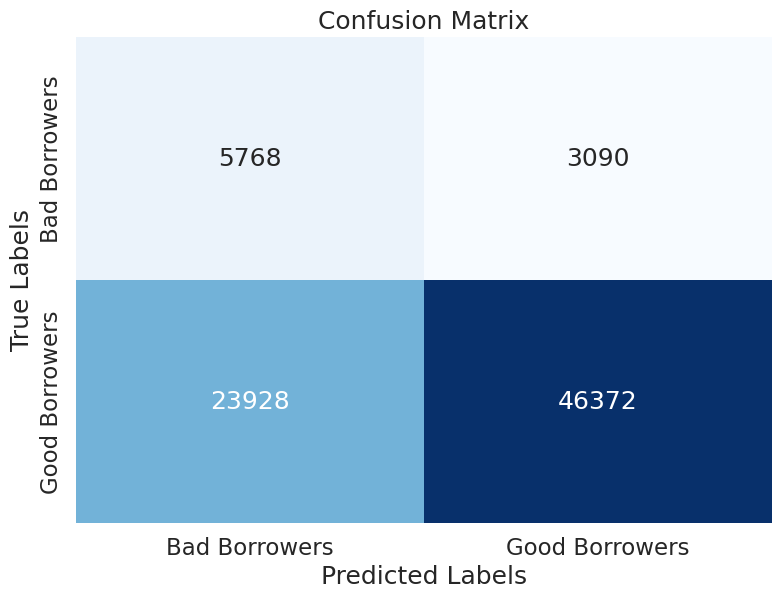

Classification Report:
                precision    recall  f1-score   support

 Bad Borrowers       0.19      0.65      0.30      8858
Good Borrowers       0.94      0.66      0.77     70300

      accuracy                           0.66     79158
     macro avg       0.57      0.66      0.54     79158
  weighted avg       0.85      0.66      0.72     79158



In [61]:
random_forest_under = train_random_forest(sampling_method='under')
random_forest_under

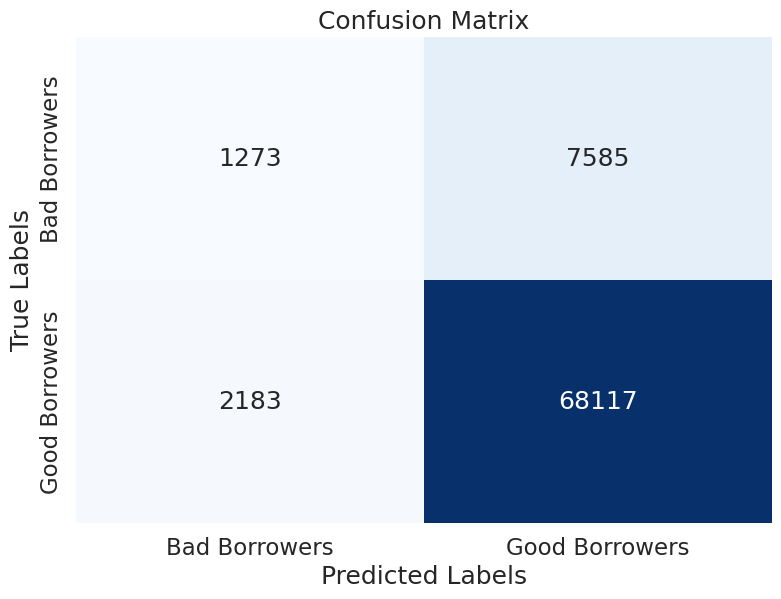

Classification Report:
                precision    recall  f1-score   support

 Bad Borrowers       0.37      0.14      0.21      8858
Good Borrowers       0.90      0.97      0.93     70300

      accuracy                           0.88     79158
     macro avg       0.63      0.56      0.57     79158
  weighted avg       0.84      0.88      0.85     79158



In [62]:
random_forest_smote = train_random_forest(sampling_method='smote')
random_forest_smote

## Logistic Regression

In [63]:
def train_reglog(sampling_method='none'):

    model = LogisticRegression(max_iter=1000)

    if sampling_method == 'over':
        # Oversampling with RandomOverSampler
        model.fit(X_train_over, y_train_over)

    elif sampling_method == 'under':
        # Undersampling with RandomUnderSampler
        model.fit(X_train_under, y_train_under)

    elif sampling_method == 'smote':
        # SMOTE
        model.fit(X_train_smote, y_train_smote)

    else:
        model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    target_names = ['Bad Borrowers', 'Good Borrowers']

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names = target_names))

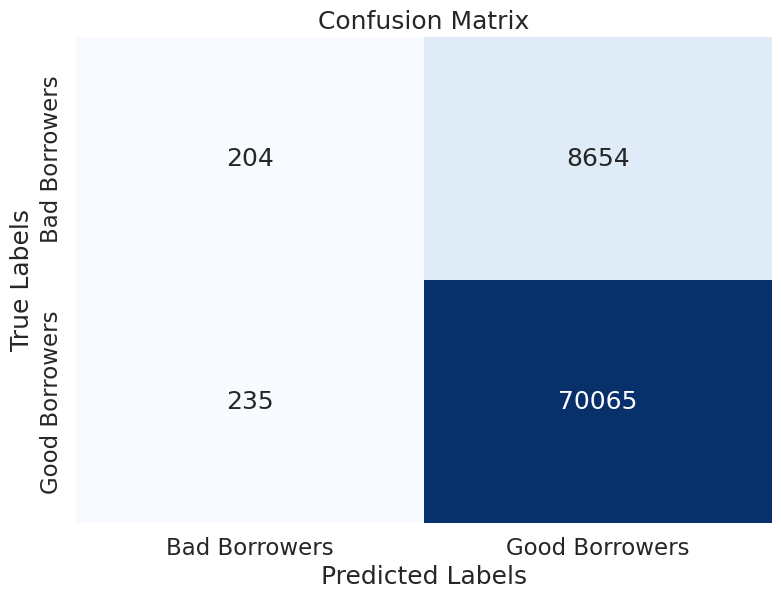

Classification Report:
                precision    recall  f1-score   support

 Bad Borrowers       0.46      0.02      0.04      8858
Good Borrowers       0.89      1.00      0.94     70300

      accuracy                           0.89     79158
     macro avg       0.68      0.51      0.49     79158
  weighted avg       0.84      0.89      0.84     79158



In [64]:
reglog = train_reglog()
reglog

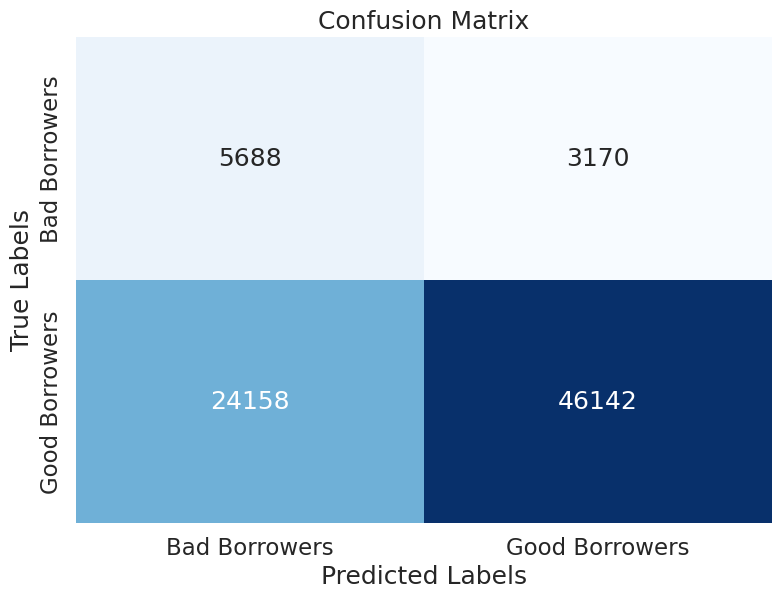

Classification Report:
                precision    recall  f1-score   support

 Bad Borrowers       0.19      0.64      0.29      8858
Good Borrowers       0.94      0.66      0.77     70300

      accuracy                           0.65     79158
     macro avg       0.56      0.65      0.53     79158
  weighted avg       0.85      0.65      0.72     79158



In [65]:
reglog_over = train_reglog(sampling_method = 'over')
reglog_over

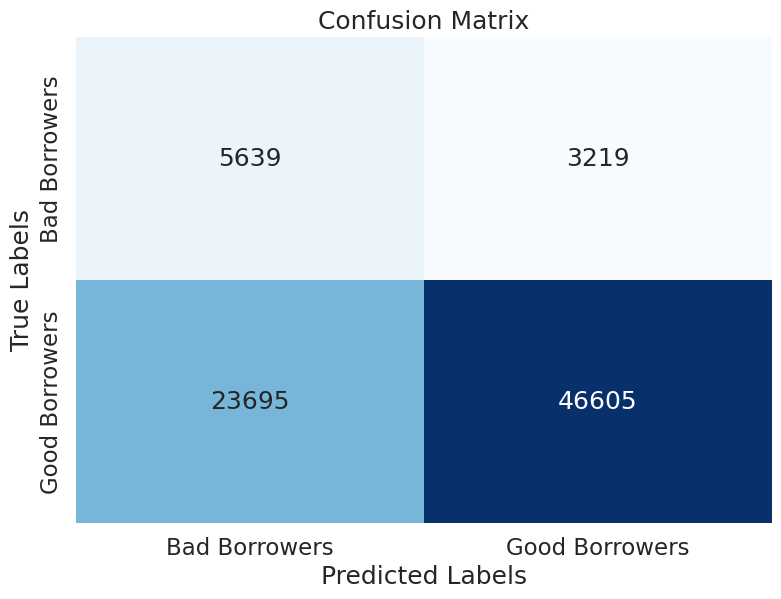

Classification Report:
                precision    recall  f1-score   support

 Bad Borrowers       0.19      0.64      0.30      8858
Good Borrowers       0.94      0.66      0.78     70300

      accuracy                           0.66     79158
     macro avg       0.56      0.65      0.54     79158
  weighted avg       0.85      0.66      0.72     79158



In [66]:
reglog_under = train_reglog(sampling_method = 'under')
reglog_under

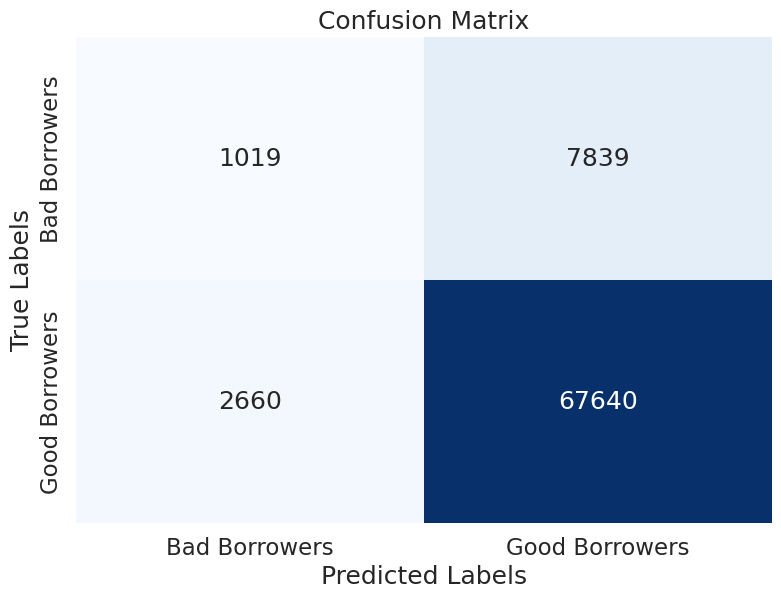

Classification Report:
                precision    recall  f1-score   support

 Bad Borrowers       0.28      0.12      0.16      8858
Good Borrowers       0.90      0.96      0.93     70300

      accuracy                           0.87     79158
     macro avg       0.59      0.54      0.55     79158
  weighted avg       0.83      0.87      0.84     79158



In [67]:
reglog_smote = train_reglog(sampling_method = 'smote')
reglog_smote

# Conclusion

*   Model terbaik adalah Random Forest menggunakan metode Random Oversampling dengan akurasi sebesar ~89%

